# Lab 4 | Noise

### Made by Dmitriy Sokolov, 3530901/00203

Firstly, prepare the environment

In [1]:
from labs.install_deps import require_think_dsp

require_think_dsp()

thinkdsp.py successfully download


-----
### Part 1

We are going to download some different nature noise sounds from *freesound.org*:
* [North Sea](https://freesound.org/people/Soarer/sounds/13793/)

In [2]:
from labs.thinkdsp import read_wave

wave = read_wave('north-sea.wav')
wave.make_audio()

Cut it:

In [3]:
segment = wave.segment(5.0, 1.0)
segment.make_audio()

And its spectrum:

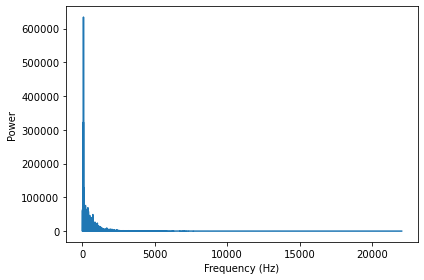

In [4]:
from labs.thinkdsp import decorate

spectrum = segment.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

It looks like decreasing power on increasing frequency, and it can be pink or red (Brownian)

Its spectrum on logarithmic scale. After 10^2 - 10^3 Hz it can decrease linearly.

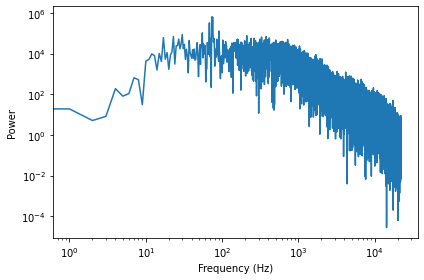

In [5]:
spectrum.plot_power()

loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)', ylabel='Power', **loglog)

Let's compare the first segment with another segment:

In [6]:
segment2 = wave.segment(start=9.0, duration=1.0)
segment2.make_audio()

They spectrum:

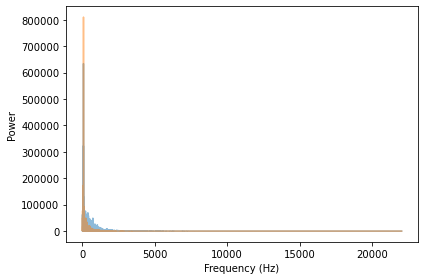

In [7]:
spectrum2 = segment2.make_spectrum()

spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

And on log scale:

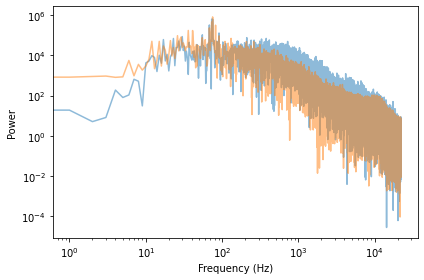

In [8]:
spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)', ylabel='Power', **loglog)

They are the similar.

-----

### Part 2

Implement Bartlett's method to measure the spectrum of noise signal power.
Here we need split a long signal into short segments, and evaluate separately them spectrum, then complete average.

In [9]:
import numpy as np
from labs.thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):
    """Estimates the power spectrum of a noise wave.
    impl: https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/master/code/chap04soln.ipynb#scrollTo=d57rxzEZI2VD
    """
    # make a spectrogram and extract the spectrums
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()

    # extract the power array from each spectrum
    psds = [spectrum.power for spectrum in spectrums]

    # compute the root mean power (which is like an amplitude)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs

    # make a Spectrum with the mean amplitudes
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

And call the fun:

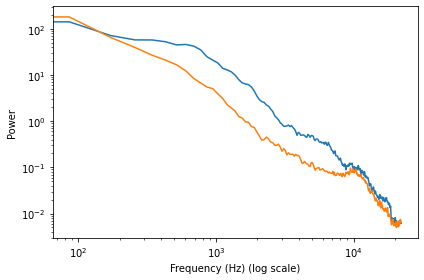

In [10]:
psd = bartlett_method(segment)
psd2 = bartlett_method(segment2)

psd.plot_power()
psd2.plot_power()
decorate(xlabel='Frequency (Hz) (log scale)', ylabel='Power', **loglog)

The relationship between two segments are clear. They have common trend. They can be approximate to linear dependency.

-----

### Part 3

Download Bitcoin day bidding price. Compute its spectrum as fun of time.

Is it similar with white/pink/Brownian noise?

We will use actual data of Bitcoin historical price (from 2014 to 2023 - per day statistics!).

Reference: [yahoo - finances](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1677801600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [11]:
import pandas as pd

df = pd.read_csv('BTC-USD_2023.csv', parse_dates=[0])

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [13]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3085,2023-02-27,23561.451172,23857.890625,23205.878906,23522.871094,23522.871094,22660763494
3086,2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,23147.353516,20535363434
3087,2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,23646.550781,24662841200
3088,2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516
3089,2023-03-03,23479.347656,23479.347656,22264.568359,22328.822266,22328.822266,25586948096


In [14]:
ys = df['Close']
ts = df.index

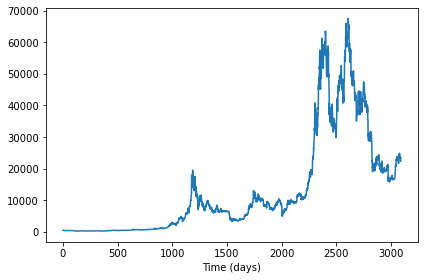

In [15]:
from labs.thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)')

Its spectrum:

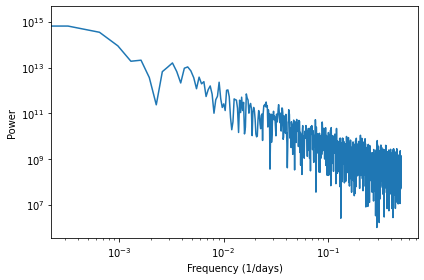

In [16]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (1/days)', ylabel='Power', **loglog)

In [17]:
spectrum.estimate_slope()[0]

-1.8186557365916476

In [18]:
from labs.thinkdsp import PinkNoise, BrownianNoise


pinkNoise = PinkNoise()
print('Pink noise slope:', pinkNoise.make_wave().make_spectrum().estimate_slope()[0])
redNoise = BrownianNoise()
print('Red (Brownian) noise slope:', redNoise.make_wave().make_spectrum().estimate_slope()[0])

Pink noise slope: -1.0035612353630823
Red (Brownian) noise slope: -1.8059381768126463


We can see, that slope of the "bitcoin spectrum" is similar with Brownian noise slope.
And we can declare, that this is red noise.

-----

### Part 4

Write `UncorrelatedPoissonNoise(Noise)` and implement `evaluate()` method.
Use `np.random.poisson` to generate random values.

Generate one-two seconds of UP and listen it. When amp is low (for example, 0.001) - the sound will be similar with original Geiger counter. However, at high values it becomes a white noise.

In [19]:
from labs.thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise):
    """Represents uncorrelated Poisson noise."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.
        ts: float array of times
        returns: float wave array
        """
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Make sound of UP at low amp (radiation sound at Geiger counter):

In [20]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

In [21]:
expected = int(amp * framerate * duration)
actual = sum(wave.ys)
print('Expected particles count:', expected)
print('Actual particles count:', actual)

Expected particles count: 10
Actual particles count: 17


The wave:

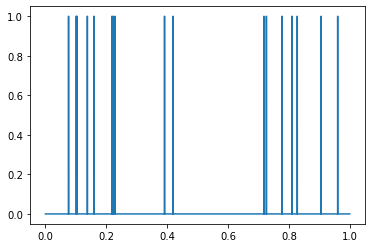

In [22]:
wave.plot()

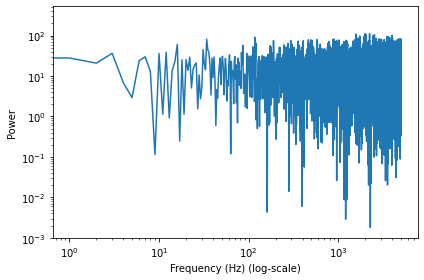

In [23]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz) (log-scale)', ylabel='Power', **loglog)

In [24]:
spectrum.estimate_slope().slope

0.014435274638168485

Its slope is close to 0, it looks like white noise.

Let's check the sound at high amp (1)

In [25]:
amp = 1
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

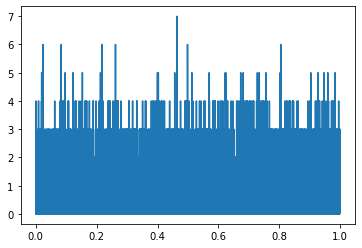

In [26]:
wave.plot()

And the plot of power's spectrum for real and imaginary part of complex power:

In [27]:
import matplotlib.pyplot as plt

def normal_prob_plot(sample, fit_color='0.8', **options):
    """Makes a normal probability plot with a fitted line.

    sample: sequence of numbers
    fit_color: color string for the fitted line
    options: passed along to Plot
    """
    n = len(sample)
    xs = np.random.normal(0, 1, n)
    xs.sort()

    ys = np.sort(sample)

    mean, std = np.mean(sample), np.std(sample)
    fit_ys = mean + std * xs
    plt.plot(xs, fit_ys, color='gray', alpha=0.5, label='model')

    plt.plot(xs, ys, **options)

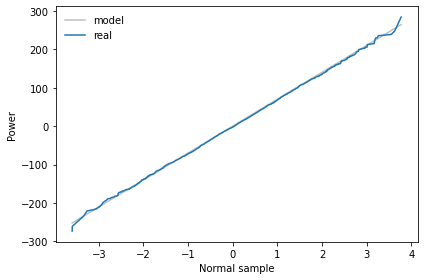

In [28]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0

normal_prob_plot(spectrum.real, label='real')
decorate(xlabel='Normal sample', ylabel='Power')

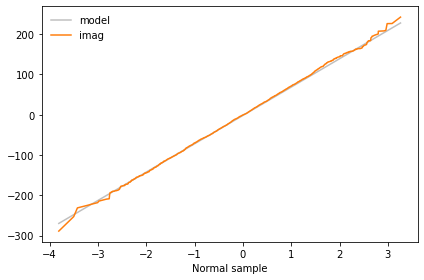

In [29]:
normal_prob_plot(spectrum.imag, label='imag', color='C1')
decorate(xlabel='Normal sample')

Here a model is Gaussian noise.

-----

### Part 5

Implement **Voss-McCartney** pink noise generation algorithm.
Compute the spectrum, and assume that power/frequency is as expected.

*The fundamental idea of the algorithm is to add up several sequences of uniform random numbers that get updated at different rates. The first source gets updated at every time step; the second source every other time step, the third source ever fourth step, and so on.*

In [30]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    nrows: number of values to generate
    rcols: number of random sources to add
    returns: NumPy array
    Impl: https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb
    """
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)

    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

In [31]:
ys = voss(10_000)

In [32]:
ys[:5]

array([6.54731767, 6.78391651, 6.42661236, 7.11044278, 6.76143651])

In [33]:
ys[-5:]

array([7.52779245, 7.7002639 , 7.6381947 , 7.19920434, 7.52261576])

The wave:

In [34]:
wave = Wave(ys)
wave.unbias()
wave.normalize()

The plot of the wave:

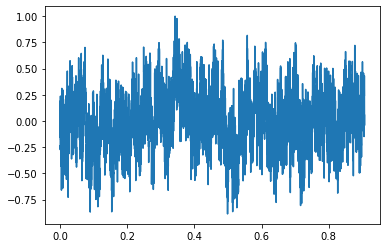

In [35]:
wave.plot()

In [36]:
wave.make_audio()

Its spectrum:

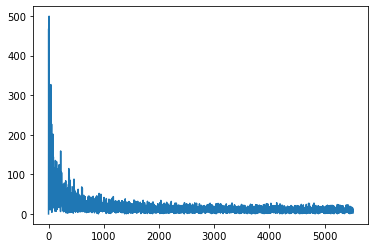

In [37]:
wave.make_spectrum().plot()

Its spectrum in log-scale:

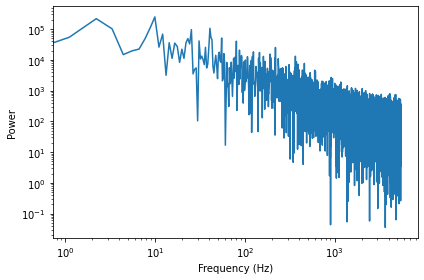

In [38]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)', ylabel='Power', **loglog)

The slope is close to -1. It is also close to pink noise close (which we early computed)

In [39]:
spectrum.estimate_slope().slope

-0.9689918101063385

Pink noise slope (repeatedly compute):

In [40]:
pinkNoise.make_wave().make_spectrum().estimate_slope()[0]

-1.004372678393794

Barlett's method to compute the average power spectrum.

In [41]:
from labs.thinkdsp import Wave

seg_length = 100_000
iters = 100
longwave = Wave(voss(seg_length * iters))
spectrum = bartlett_method(longwave, seg_length=seg_length, win_flag=False)
spectrum.hs[0] = 0
len(spectrum)

50001

And its power/frequency dependency

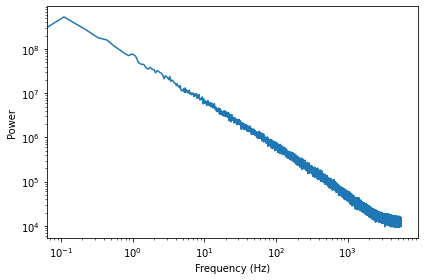

In [42]:
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)', ylabel='Power', **loglog)

And, of course, its slope is also equals -1. It is a pink noise.

In [43]:
spectrum.estimate_slope().slope

-1.001524567220517